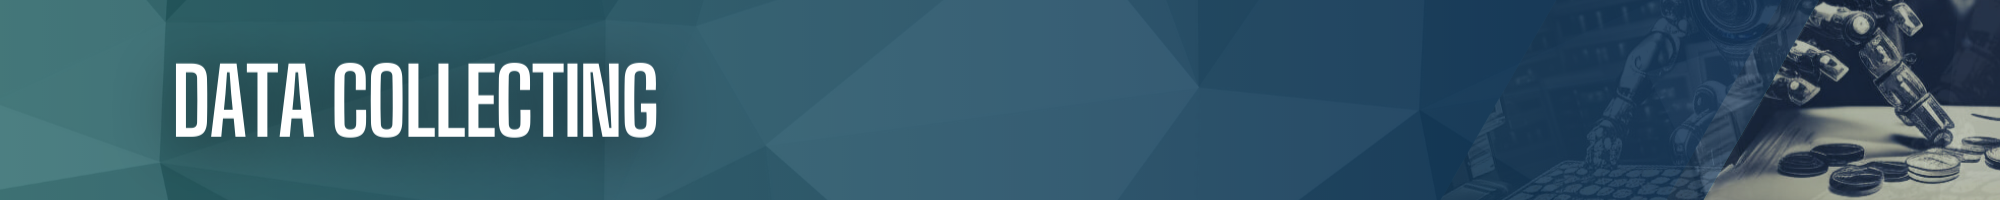

<div style="background-color: #f7f7f7; padding: 20px; border-radius: 10px; border: 2px solid #333333;">

<h1 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Gameplan</h1>

<ul style="font-family: Arial, sans-serif; color: #555555;">
    <li><strong>Acquiring the Proper HTML Responses:</strong> Obtain the necessary HTML responses from the <a href="https://en.numista.com/" style="color: #0088cc; text-decoration: none;">Numista</a> website.</li>
    <li><strong>Investigating Website Structure:</strong> Carefully analyze the structure of the website and identify the specific elements that contain the desired data.</li>
    <li><strong>Setting up an Efficient Web Crawler:</strong> Establish a sophisticated and highly efficient web crawler to systematically gather the required information.</li>
    <li><strong>Handling Bugs and Roadblocks:</strong> Address any unexpected issues and overcome obstacles that may arise during the crawling process.</li>
    <li><strong>Executing the Web Crawler:</strong> Execute the web crawler to diligently collect the necessary data.</li>
</ul>

<h1 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Goal</h1>

<ul style="font-family: Arial, sans-serif; color: #555555;">
    <li><strong>Achieving a Comprehensive Dataset:</strong> Attain a dataset of considerable size, enriched with an abundant amount of data, to serve as the foundation for training machine learning models.</li>
</ul>

</div>



In [1]:
import requests
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
from IPython.display import display, Code
import time
import datetime
import csv
import json
import math
import os
import warnings
from bs4 import BeautifulSoup
from pprint import pprint
from IPython.display import display
from collections import OrderedDict
from tabulate import tabulate

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">Starting with a "soft" attempt to get a response .</span>

</div>

In [2]:
response = requests.get('https://en.numista.com/catalogue/index.php?ct=coin')
soup = BeautifulSoup(response.content, 'html.parser')
pprint(soup.prettify()) 

('<!DOCTYPE html>\n'
 '<html lang="en">\n'
 ' <head>\n'
 '  <title>\n'
 '   Captcha verification – Numista\n'
 '  </title>\n'
 '  <meta charset="utf-8"/>\n'
 '  <meta content="width=device-width" name="viewport"/>\n'
 '  <meta content="initial-scale=1.0" name="viewport"/>\n'
 '  <script async="" defer="" '
 'src="https://www.recaptcha.net/recaptcha/api.js">\n'
 '  </script>\n'
 ' </head>\n'
 ' <body>\n'
 '  <form action="/catalogue/index.php?ct=coin" method="post">\n'
 '   <p>\n'
 '    Numista was not able to fulfill your query. Please complete the Captcha '
 'below.\n'
 '   </p>\n'
 '   <div class="g-recaptcha" '
 'data-sitekey="6LfAFQsTAAAAAFIwtCYcfjqOhuXJGDej5cHK49ux">\n'
 '   </div>\n'
 '   <br/>\n'
 '   <input type="submit" value="Submit"/>\n'
 '  </form>\n'
 ' </body>\n'
 '</html>\n')


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">The response received was a captcha test instead of the expected HTML.<br>Another request will be made, this time utilizing "headers" to emulate a browser request.</span>

</div>

# Code Block with Large Output Removed to Maintain Readability
## The original code block with the output is located in the "FullCode" notebook.

Code Used:<br>
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
response = requests.get('https://en.numista.com/catalogue/index.php?ct=coin', headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
html_code = soup.prettify()

display(Code(html_code, language='html'))

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;"> Better.<br>
Upon reviewing the data, it is evident that the list of locations is enclosed within an element called "liste_pays".<br>To proceed with the web-crawling process, I will aim to gather a collection of URL "tails" for appropriate configuration.</span>

</div>

# Code Block with Large Output Removed to Maintain Readability
## The original code block with the output is located in the "FullCode" notebook.

Code Used:<br>
ul_element = soup.find('ul', class_='liste_pays')<br>
<br>
if ul_element is not None:<br>
    a_tags = ul_element.find_all('a')<br>
    locations = [a_tag['href'][:-6] for a_tag in a_tags] # remove the last 6 characters ('1.html') from each href<br>
    pprint(locations)<br>


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;"> Excellent! Let's proceed with sorting the list.</span>

</div>

# Code Block with Large Output Removed to Maintain Readability
## The original code block with the output is located in the "FullCode" notebook.

Code Used:<br>
locations = list(set(locations))<br>
locations.sort()<br>
locations.pop(0) #The first element, after sorting, was found to be irrelevant <br>
pprint(locations)<br>

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;"> The list of URL "tails" has been prepared.<br>
        Next, these tails will be used to visit all the location pages on the website and collect the unique index of each coin.</span>

</div>

In [6]:
# This is to handle potential instances of infinite loops encountered during the testing phase...
def is_duplicate(coin_id, existing_ids):
    for existing_id in existing_ids:
        if coin_id == existing_id:
            return True
    return False

In [ ]:
coin_ids = []  # Initialize a list to store the collected coin IDs
start_tme = datetime.datetime.now()  # Record the starting time

# Iterate through locations
for count, location in enumerate(locations, 1):
    page_num = 1  # Initialize the page number
    prev_coin_ids_len = len(coin_ids)  # Record the length of the coin IDs list
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}]")

    # Start scraping pages
    while True:
        url = f"https://en.numista.com/{location}{page_num}.html"
        print(f"- Scraping page #{page_num} location #{count}/{len(locations)}: {url}")

        try:
            response = requests.get(url, headers=headers, allow_redirects=False)
            
            # Check response status code
            if response.status_code == 404:
                print(f"Invalid URL: {url}. Moving to next location.")
                break
            elif response.status_code == 302:
                print(f"Redirected URL: {url}. Moving to next page.")
                break
            else:
                soup = BeautifulSoup(response.content, 'html.parser')
                description_pieces = soup.find_all('div', {'class': 'description_piece'})
                
                # Extract coin IDs from the page
                for piece in description_pieces:
                    a_tags = piece.find_all('a')
                    for a in a_tags:
                        href = a['href']
                        start_index = href.find('pieces') + len('pieces') + 1
                        end_index = href.find('.html')
                        coin_id = href[start_index:end_index]
                        
                        # Check if the coin ID is a duplicate
                        if is_duplicate(coin_id, coin_ids):
                            print(f"Duplicate coin ID found: {coin_id}. Moving to next page.")
                            break
                        else:
                            coin_ids.append(coin_id)
                    else:
                        continue
                    break

                curr_coin_ids_len = len(coin_ids)
                
                # Check if there are more pages to scrape for the current location
                if curr_coin_ids_len == prev_coin_ids_len:
                    print(f"No more pages for '{location}'. Moving to next location.")
                    break
                else:
                    prev_coin_ids_len = curr_coin_ids_len
                    page_num += 1
                    time.sleep(0.5)
        except requests.exceptions.RequestException as e:
            print(f"An error occurred while requesting {url}: {e}")
            break

    print(f"Collected {len(coin_ids)} coin IDs so far\n")

# Calculate elapsed time
elapsed_time = datetime.datetime.now() - start_time
elapsed_time_str = str(elapsed_time).split('.')[0]
print(f"\nFinished crawling {len(coin_ids)} URLs. Time taken: {elapsed_time_str}.\n")

# Code Block with Large Output Removed to Maintain Readability
## The original code block with the output is located in the "FullCode" notebook.

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;"> The HTML structure of the "section" part is being explored to locate the desired elements.<br>
        Additionally, one of the pages (e.g., 'https://en.numista.com/catalogue/pieces8562.html') is being parsed to examine its content.</span>

</div>

In [8]:
url = 'https://en.numista.com/catalogue/pieces8562.html'
response = requests.get(url, headers=headers, allow_redirects=False)
soup = BeautifulSoup(response.content, 'html.parser')
section = soup.find('section', {'id': 'fiche_caracteristiques'})
print(section.prettify())

<section id="fiche_caracteristiques">
 <h3>
  Features
 </h3>
 <table>
  <tr>
   <th>
    Issuer
   </th>
   <td>
    <a href="/catalogue/ddr-1.html">
     German Democratic Republic
    </a>
    (Germany)
    <img alt="" height="16" src="https://en.numista.com/design/pays/ddr.gif" style="margin-bottom:-3px;" title="German Democratic Republic" width="16"/>
   </td>
  </tr>
  <tr>
   <th>
    Period
   </th>
   <td>
    <a href="/catalogue/ruler.php?id=1313">
     Republic                                        (
     <em>
      1948-1990
     </em>
     )
    </a>
    <br/>
   </td>
  </tr>
  <tr>
   <th>
    Type
   </th>
   <td>
    Standard circulation coin
   </td>
  </tr>
  <tr>
   <th>
    Years
   </th>
   <td>
    1948-1950
   </td>
  </tr>
  <tr>
   <th>
    Value
   </th>
   <td>
    1 Pfennig
                (0.01&amp;nbspDDM)
   </td>
  </tr>
  <tr>
   <th>
    Currency
   </th>
   <td>
    Mark (
    <em>
     1948-1990
    </em>
    )
   </td>
  </tr>
  <tr>
   <th>
    C

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  The webpage features a well-structured table with valuable information.<br>The following code block demonstrates the extraction process for retrieving data from the table.</span>

</div>

In [9]:
# Extracting data from the table
table = section

# Initializing variables
coin_data = {}
col_names = []

# Iterating through each row in the table
for row in table.find_all("tr"):
    # Extracting parameter name
    parameter_name = row.find("th").text.strip()
    
    # Extracting parameter value
    parameter_value = ""
    if row.find("a"):
        parameter_value = row.find("a").text.strip()
    elif row.find("td"):
        parameter_value = row.find("td").text.strip()

    # Adding parameter name to the list of column names if it's not already present
    if parameter_name not in col_names:
        col_names.append(parameter_name)
    
    # Storing parameter value in the coin_data dictionary
    coin_data[parameter_name] = parameter_value
    
# Creating a DataFrame from the collected data
df = pd.DataFrame(columns=col_names)
df.loc[0] = [coin_data.get(col_name, "") for col_name in col_names]

# Adjusting the index and column names
df.index = [url.split("/")[-1].replace("pieces", "").replace(".html", "")]
df = df.rename_axis("Index").reset_index()

# Displaying the DataFrame
display(df)


,Index,Issuer,Period,Type,Years,Value,Currency,Composition,Weight,Diameter,Thickness,Shape,Technique,Orientation,Demonetized,Number,References
0,8562,German Democratic Republic,Republic ...,Standard circulation coin,1948-1950,1 Pfennig\n (0.01&nbspDDM),Mark (1948-1990),Aluminium,0.75 g,17 mm,2 mm,Round,Milled,Medal alignment ↑↑,31 December 1970,N# 8562,KM


<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; border: 1px solid #333333;">

<span style="font-family: Arial, sans-serif; color: #555555;">  This concludes the testing phase.<br>
        The current objective is to develop efficient functions for large-scale crawling, and ultimately executing the web crawler.</span>

</div>

In [10]:
def scrape_title(soup):
    try:
        # Find the header element containing the main title
        header_element = soup.find('header', {'id': 'main_title'})
        # Extract the title text and remove any leading or trailing whitespace
        title = header_element.find('h1').text.strip()
        # Print confirmation that the title was successfully scraped
        print(f"- title: OK")
    except AttributeError:
        # Handle the case where the 'Title' element is not found
        print(f"Error: Failed to locate 'Title' element")
        # Assign NaN (not a number) to the title
        title = math.nan
    except Exception as e:
        # Handle any other exceptions that may occur during scraping
        print(f"Error: {e}. Failed to scrape 'Title'")
        # Assign NaN to the title
        title = math.nan
        
    # Return the scraped title
    return title


In [11]:
"""
This function is designed to look for parameters I may have missed in the early analysis of the web page structure.
It iterates through each table row, extracting parameter names and values.
Hyperlinks or plain text values are assigned to corresponding parameters.
New parameter names are added to existing columns if not present.

"""

def scrape_characteristics(soup):
    try:
        # Find the table element containing characteristics
        table_element = soup.find('section', {'id': 'fiche_caracteristiques'}).find('table')
        
        # Initialize with default columns
        coin_data = {'Index': coin_id, 'Title': title, 'Rarity': rarity}
        col_names = ['Index', 'Title', 'Rarity']
        
        # Extract characteristics from each row
        for row in table_element.find_all("tr"):
            parameter_name = row.find("th").text.strip()
            parameter_value = math.nan
            
            # Check if value exists as a link or as a plain text
            if row.find("a"):
                parameter_value = row.find("a").text.strip()
            elif row.find("td"):
                parameter_value = row.find("td").text.strip()
            
            # Add new parameter to column names if it's not already present
            if parameter_name not in col_names:
                col_names.append(parameter_name)
                
            # Assign parameter value to coin data
            coin_data[parameter_name] = parameter_value
    except Exception as e:
        print(f"Error: {e}. Failed to scrape 'Table of characteristics'")
        # Return default columns and values in case of error
        coin_data = {'Index': coin_id, 'Title': title, 'Rarity': rarity}
        col_names = ['Index', 'Title', 'Rarity']
        
    # Print status
    print(f"- characteristics: OK")
    
    # Return scraped coin data and column names
    return coin_data, col_names


In [12]:
def scrape_rarity(soup):
    try:
        # Find the div containing rarity information
        div = soup.find('div', style='padding:25px 0 5px 0')

        # Find the strong tag within the div
        strong = div.find('strong')

        # Extract the rarity text
        rarity = strong.text

        # Print status message
        print(f"- Rarity: OK")
    except Exception as e:
        # Handle exception and print error message
        print(f"Error: {e}. Failed to scrape 'Rarity'")
        rarity = math.nan

    # Return the rarity
    return rarity


In [13]:
def scrape_edge(soup):
    try:
        # Find the section containing descriptions and locate the heading for 'Edge'
        edge_element = soup.find('section', {'id': 'fiche_descriptions'}).find('h3', text='Edge').find_next_sibling('p')
        
        # Extract the text of the next sibling paragraph if it exists, otherwise assign an empty string
        edge = edge_element.text.strip() if edge_element else ''
        
        # Print a message indicating successful scraping of 'Edge'
        print(f"- edge: OK")
    except Exception as e:
        # Print an error message if scraping fails and assign a value indicating failure
        print(f"Error: {e}. Failed to scrape 'Edge'")
        edge = math.nan
        
    return edge


In [14]:
def scrape_engraver(soup):
    try:
        # Find the 'Engraver' element
        engraver_element = soup.find('section', {'id': 'fiche_descriptions'}).find('strong', text='Engraver:')
        
        if engraver_element:
            if engraver_element.find_next_sibling('span', class_='engraver_link'):
                # Extract the engraver from the sibling span element
                engraver = engraver_element.find_next_sibling('span', class_='engraver_link').text.strip()
            else:
                # Extract the engraver from the next sibling
                engraver = engraver_element.next_sibling.strip()
                
            # Print success message
            print(f"- engraver: OK")
        else:
            # Handle case when 'Engraver' element is not found
            engraver = math.nan
    except AttributeError:
        # Handle attribute error when 'Engraver' element is not located
        print(f"Error: Failed to locate 'Engraver' element")
        engraver = math.nan
    except Exception as e:
        # Handle any other exceptions during scraping
        print(f"Error: {e}. Failed to scrape 'Engraver'")
        engraver = math.nan
    
    # Return the extracted engraver
    return engraver


In [15]:
"""
This function incorporates early feature engineering techniques. 
Specifically, the 'Times Issued' column of the dataset is dynamically generated during 
the scraping process for the 'Mintage' column.

""" 

def scrape_coin_mintage(soup):
    # Find all elements with the class "tirage"
    mintage_elements = soup.select("td.tirage")

    # If no mintage elements found, return None for mintage and 0 for numeric_mintage_counter
    if not mintage_elements:
        return None, 0

    mintage = None
    numeric_mintage_counter = 0

    # Iterate over each mintage element
    for element in mintage_elements:
        # Check if the element's text is not empty
        if element.text.strip():
            # Check if the element's text is numeric
            if element.text.strip().replace('\u202f', '').isnumeric():
                numeric_mintage_counter += 1
                # If mintage is not set, set it to the current element's text
                if not mintage:
                    mintage = element.text.strip().replace('\u202f', '')
            else:
                # Print a message for non-numeric mintage value
                print(f"Skipping non-numeric mintage value: {element.text.strip()}")

    # If mintage is still not set, return None for mintage and the numeric_mintage_counter
    if not mintage:
        return None, numeric_mintage_counter

    # Print a message indicating successful mintage retrieval
    print(f"- mintage: OK")

    # Return the mintage and numeric_mintage_counter
    return mintage, numeric_mintage_counter